<a href="https://colab.research.google.com/github/coly1119/36-350/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="logo.jpg" width="200"/>
</div>

#Is it Legendary?


#Introduction

Pokemon was a big part of our childhoods. We grew up hunting legendary Pokemon and battling our way to the top of the game. There are Pokemon that are better than others and Pokemon that are very useful for very specific situations like swimming in water or breaking down boulders. These traits and abilities are decided by the stats each Pokemon have. Pokemon have different types and abilities like speed, attack, and defense. These stats allow for a very rich data set on Pokemon and can allow for us to make inferences about Pokemon and how they relate. 
We thus wanted to see if we could use these stats to predict whether or not a Pokemon is a legendary. That is to say, is there a feature set that can be used to define the legendary class. Our process will look like the following:
<div>
<img src="wf.jpg" width="600"/>
</div>



##Data Retrieval

Information on the stats of each Pokemon are stored in a database called the Pokedex in the games, movies, and shows. A website called serebii.net contains the Pokedex entry for every Pokemon in all eight generations.
We used Beautiful Soup to parse the html of the web page and retreieve the stats of each Pokemon. We then hand labeled each Pokemon as legendary or not by searching through the list of legendary Pokemon on cerebii.net. 
Unfortunately, there are only 73 legendary Pokemon out of 890 Pokemon which is about 8.2 percent of all Pokemon. This is a small amount of data points and would thus be really hard to accurately predict. To fix this, we decided to look at the stats of legendary Pokemon and see if we could find some basic correlation of the values of stats and whether a Pokemon was legendary or not. 

Below are the necessary packages (as well as sklearn used later) for this project. Any missing projects can be installed with the pip install command. For further questions, address: https://pip.pypa.io/en/stable/reference/pip_install/

In [0]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
from plotnine import *
%matplotlib inline

Scraping the webpage (https://serebii.net/pokemon/all.shtml) with all of the Pokemon listed with their individual stats is down in the block below.

In [0]:
def get_Pokemon(url):
    #initialize BeautifulSoup and variables
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html5lib')
    i = 0
    data_mat = []

    #scrape website for Pokemon stats
    for pokemon in soup.find_all('td',attrs = {'align': 'center', "class": ["fooinfo","fooben"]}):
        if i % 11 == 2:
            stats = []
            #name of Pokemon
            stats.append(pokemon.text.strip())
        elif i % 11 == 3:
            #type of Pokemon
            types = []
            for ty in pokemon.find_all('a',href=re.compile('/pokemon/type/(.*)')):
                curr = re.search('/pokemon/type/(.*)', ty["href"]).group(1).upper()
                types.append(curr)
            stats.append(types)
        elif i % 11 > 4 and i % 11 < 10:
            #stats of Pokemon
            stats.append(float(pokemon.text.strip()))
        elif i % 11 == 10:
            #final of Pokemon, append to the overal list
            stats.append(float(pokemon.text.strip()))
            data_mat.append(stats)
        
        i += 1
    
    #convert to pandas data frame
    df = pd.DataFrame(data_mat, columns=['Name', 'Type', 'HP', "Att", "Def", "S.Att", "S.Def", "Spd"])
    #df = df.set_index('Nat ID')
    return df

In [0]:
#scrape website
poke_dat = get_Pokemon("https://serebii.net/pokemon/all.shtml")

Unfortunately, Serebii didn't have an available list of  legendaries. No need to panic, however, as we can make our own column corresponding to whether a Pokemon is legendary.

In [122]:
#add legendaries column
legendaries = {"Articuno", "Zapdos", "Moltres", "Mewtwo", "Mew", "Raikou", "Entei", 
               "Suicune", "Lugia", "Ho-Oh", "Celebi", "Regirock", "Regice", "Registeel",
               "Latias", "Latios", "Kyogre", "Groudon", "Rayquaza", "Jirachi", "Deoxys",
               "Uxie", "Mesprit", "Azelf", "Dialga", "Palkia", "Heatran", "Regigigas", 
               "Giratina", "Cresselia", "Phione", "Manaphy", "Darkrai", "Shaymin", 
               "Arceus", "Victini", "Cobalion", "Terrakion", "Virizion", "Tornadus",
               "Thundurus", "Reshiram", "Zekrom", "Landorus", "Kyurem", "Keldeo",
               "Meloetta", "Genesect", "Xerneas", "Yveltal", "Zygarde", "Diancie",
               "Hoopa", "Volcanion", "Type: Null", "Silvally", "Tapu Koko", "Tapu Lele",
               "Tapu Bulu", "Tapu Fini", "Cosmog", "Cosmoem", "Solgaleo", "Lunala", 
               "Necrozma", "Magearna", "Marshadow", "Zeraora", "Meltan", "Melmetal",
               "Zacian", "Zamazenta", "Eternatus"}
is_legend = [float(name in legendaries) for name in poke_dat["Name"]]

poke_dat["Legend"]  = is_legend
poke_dat.head(5)

Name             Type    HP   Att   Def  S.Att  S.Def   Spd  Legend
0   Bulbasaur  [GRASS, POISON]  45.0  49.0  49.0   65.0   65.0  45.0     0.0
1     Ivysaur  [GRASS, POISON]  60.0  62.0  63.0   80.0   80.0  60.0     0.0
2    Venusaur  [GRASS, POISON]  80.0  82.0  83.0  100.0  100.0  80.0     0.0
3  Charmander           [FIRE]  39.0  52.0  43.0   60.0   50.0  65.0     0.0
4  Charmeleon           [FIRE]  58.0  64.0  58.0   80.0   65.0  80.0     0.0

In the table, $Name$ corresponds to the pokemons name, $Type$ corresponds to the type (similar to a tribe) that a Pokemon belongs to (a Pokemon can have 1 or 2 types),$HP$ corresponds to hp, $Att$ corresponds to attack, $Def$ corresponds to defense, $S. Att$ corresponds to special attack, $S.Def$ corresponds to special defense, and $Spd$ corresponds to speed. We continue with Exploratory Data Analysis.

#Exploratory Data Analysis
Let's observe what we can about the known Pokemon universe. First, we will find the overal mean of individual stats of both legendary and non-lengendary Pokemon.

In [123]:
#get means of pokemon inidividual Pokemon stats
legs = poke_dat[poke_dat["Legend"] == 1.0]
non_legs = poke_dat[poke_dat["Legend"] == 0.0]

print(legs.iloc[:,2:-1].mean(axis = 0))
print(non_legs.iloc[:,2:-1].mean(axis = 0))

HP        92.821918
Att      103.972603
Def       99.958904
S.Att    107.438356
S.Def    102.821918
Spd       93.863014
dtype: float64
HP       66.547124
Att      73.827417
Def      69.304774
S.Att    66.162791
S.Def    66.913097
Spd      63.137087
dtype: float64


As we can see, the average stats of a legendary Pokemon are higher than those of a non-legendary. We found that legendary Pokemon tend to have higher stats across the board with an average hp of 92.82, an average attack of 103.97, an average defense of 99.96, an average special attack of 107.44, and average special defense of 102.82, and an average speed of 93.86. This is contrary to the stats of the non-legendary Pokemon, whose average hp is 66.55, attack is 73.83, defense is 69.30, special attack is 66.16, special defense is 66.91, and speed is 63.14. Let's take a look into the distribution of the different types that Pokemon from both data sets belong to. 


/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


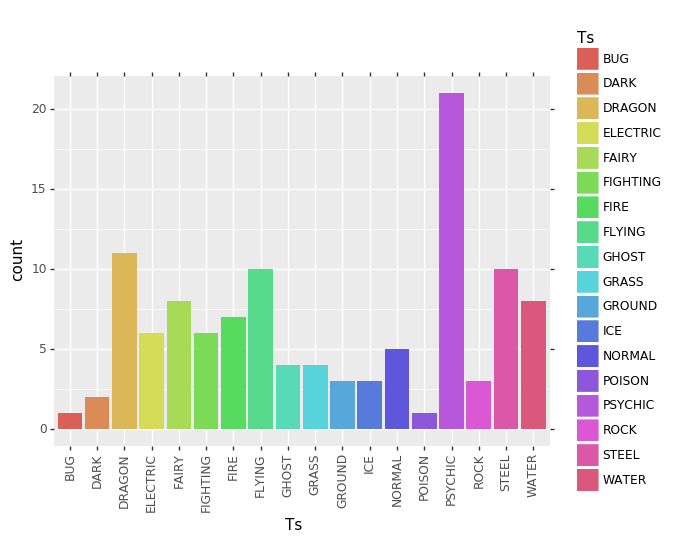

<ggplot: (-9223363267200341111)>

In [124]:
#get chart for type distribution of Legendary Pokemon
leg_ts = []
for mon in legs["Type"]:
    for t in mon:
        leg_ts.append(t)

leg_tdf = pd.DataFrame(leg_ts, columns = ["Ts"])
(ggplot(leg_tdf) + geom_bar(aes(x = "Ts", fill = "Ts")) + 
 theme(axis_text_x=element_text(rotation=90)))
    

There appears to be a large proportion of psychic type Pokemon in the legngendary set, with only one bug, and one poison type. The distribution does not appear to be uniform in any manner.  

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


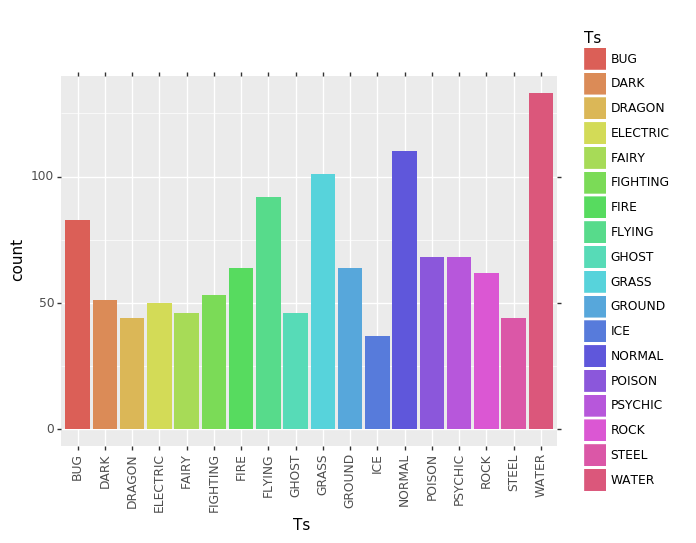

<ggplot: (-9223363267209875298)>

In [125]:
#get chart for type distribution of Non-legendary Pokemon
nleg_ts = []
for mon in non_legs["Type"]:
    for t in mon:
        nleg_ts.append(t)

nleg_tdf = pd.DataFrame(nleg_ts, columns = ["Ts"])
(ggplot(nleg_tdf) + geom_bar(aes(x = "Ts", fill = "Ts")) + 
 theme(axis_text_x=element_text(rotation=90)))

The type distribution for the the non-legendary Pokemon appears to be relatively more uniform, with many more water, bug, and normal type Pokemon. However, due to the fact that Pokemon have variable numbers of Types, the Type feature has been removed from both of our models.

Now that we have looked into the type distribution of Pokemon, let's continue with multivariate analysis. We start by plotting the correlations between the predictors, and then plotting the response vs two variables with high correlation. 

In [126]:
corr = poke_dat.iloc[:,:-1].corr()
corr.style.background_gradient(cmap='coolwarm')

It is surprising to see relatively low correlation between the stats. We will vizualize the data on a scatter plot of special defense vs defense, colored by a Pokemons Legendary status.

In [127]:
(ggplot(poke_dat) + geom_point(aes(x = "S.Def", y = "Def", color = "Legend")))

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


<ggplot: (-9223363267209040675)>

Although this is a 2D representation of the data, it would appear as though the legendaries do not for a clear cluster appart from the non-legendaries, despite the large difference in stats. We want to further investigate the relationship between base stats of Pokemon and their legendary status by initially testing a Support Vector Machine model. 

#Inital Model: SVM
We want to gain more intuition on the data by first testing a preliminary SVM model. We hypothesis that due to the fact that the data set is small, the results of the SVM may be misleading. 
For more information on the SVM Model and its differnt kernels, please visit: https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72.

The code for the SVM is as follows. 

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#get features and labels
X = poke_dat.drop(["Name", "Type","Legend"], axis=1)
y = poke_dat['Legend']

#get train, test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

#fit SVM and predict                               
sv = SVC(kernel='linear')
sv.fit(X_train, y_train)

y_pred = sv.predict(X_test)

#print accuracy
print(sum(y_pred == y_test)/len(y_pred))



0.9662921348314607


Wow no way! A simple SVM model got us 90% accuracy? There must be something wrong with our current approach. This was an error that we had also made at the time of video submission. Let's consider another metric: let's count the number of legendaries that the SVM predicted correctly/ number of legendaries. 

In [129]:
mislab = []

for i in range(len(y_pred)):
    if (y_test.iloc[i] == 1and y_pred[i] == 1):
        mislab.append(1.0)
    else:
        mislab.append(0.0) 
print(sum(mislab)/sum(y_pred))



0.8333333333333334


Now that we see that the predictor labels only 75% of the data as legendary, why is this the case? Thinking back to the data set, only 8% of the data was legendary. This means that the predictor was better at determining whether a pokemon is non-legendary by simply picking non-legendary most of the time. We will pursue a different model: a K-means model with gradient boosting. We choose this model based on our hypothesis that legendaries can be clustered away from non-legendaries based on their base stats using an unsupervised learning technique. 

#K-means Clustering with Gradient Boosting

Our goal with the K-means clustering is to cluster the Pokemon into the two groups. The number of clusters selected is based on manually iterating through values from 0 to 10 and taking the value of k with the highest score. Below is the code for the clustering.

In [136]:
# CODE FOR RUNNING THE CLUSTERING ON THE DATA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier as GB
from collections import Counter
cluster_points = poke_dat.reset_index().values[:,3:len(poke_dat.columns)-2]
#print(cluster_points)
poke_clust = KMeans(n_clusters = 9).fit(cluster_points)
sizes = Counter(poke_clust.labels_)
legend_labels = []
for i in range(len(is_legend)):
  if is_legend[i] == 1.0:
    legend_labels.append(poke_clust.labels_[i])
legend_sizes = Counter(legend_labels)
print("sizes", sizes)
print("legend_sizes", legend_sizes)
#print("legend percent", len(legendaries)/poke_dat.count())
#print("legends", len(legendaries))
#print("total", poke_dat.count)

sizes Counter({5: 182, 2: 137, 6: 129, 7: 109, 4: 99, 8: 86, 3: 81, 1: 53, 0: 14})
legend_sizes Counter({3: 42, 4: 10, 1: 7, 8: 7, 6: 5, 5: 1, 2: 1})


As we can see from the above code output, the majority of legendary Pokemon can be found in cluster 3, which has 52 + 172 = 224 Pokemon in total. This has increased the number of values in the category we want to predict for from 8 percent to 23 percent! We now want to gradient boost based on the cluster assigned.
Let's randomize the data to ensure that there is an even distribution of Pokemon from cluster 1 in both the train and test sections of data.

In [137]:
# NOTE DATA SPLITTING
rows = poke_dat.count()
print("rows", rows)
test_indices = np.random.choice(890, 178, replace = False)
test_set = set(test_indices)
train_indices = []
for i in range(890):
  if i not in test_set:
    train_indices.append(i)
print(len(cluster_points[test_indices,:]))
print(len(cluster_points[train_indices,:]))

legend_labels = poke_dat.reset_index().values[:,len(poke_dat.columns)]
print(legend_labels)
legend_train = []
for index in train_indices:
  if legend_labels[index] == 1:
    legend_train.append(1.0)
  else:
    legend_train.append(0.0)
legend_test = []
for index in test_indices:
  if legend_labels[index] == 1.0:
    legend_test.append(1.0)
  else:
    legend_test.append(0.0)

# NOTE NOW CHECK THE DISTRIBUTION OF VALUES IN TRAIN AND TEST
print(Counter(poke_clust.labels_[test_indices]))
print(Counter(poke_clust.labels_[train_indices]))
#print(legend_test)

rows Name      890
Type      890
HP        890
Att       890
Def       890
S.Att     890
S.Def     890
Spd       890
Legend    890
dtype: int64
178
712
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 1.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

As we can see the distribution of values is about the same between the train and test sets. This means we can train on the train set and make predictions on the test set to assess the accuracy of our model. We will now proceed with the gradient boosting. We want to boost in order to penalize incorrectly classified points more heavily. For further information on boosting, please visit: https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab.


In [138]:
# NOTE TIME TO MODEL
# FIRST CAN TRY MODELING DIRECTLY ON THE LEGENDARIES
legend_mod = GB().fit(cluster_points[train_indices,:],legend_train)
legend_mod.score(cluster_points[test_indices,:],legend_test)

0.9550561797752809

The overall accuracy after is satisfactory, but the goal of the problem is to label whether a pokemon is strong or not, which by our hypothesis would mean that the Pokemon is legendary. Thus, we will label the cluster with the most legendary Pokemon after boosting as the Legendary Cluster, and the other clusters as the Non-legendary cluster.

In [139]:
# NOTE NOW NEED TO CREATE A LABEL FOR THE LARGER CLUSTER
max_size = 0
max_clust = 0
for clust in legend_sizes:
  if legend_sizes[clust] > max_size:
    max_size = legend_sizes[clust]
    max_clust = clust
is_max_clust = []
for lab in poke_clust.labels_:
  if lab == max_clust:
    is_max_clust.append(1.0)
  else:
    is_max_clust.append(0.0)
is_max_clust_train = []
is_max_clust_test = []
for i in range(len(is_max_clust)):
  if i in test_set:
    is_max_clust_test.append(is_max_clust[i])
  else:
    is_max_clust_train.append(is_max_clust[i])
print(len(is_max_clust_train))
print(len(is_max_clust_test))
print(is_max_clust_test)
print(Counter(is_max_clust_test))
print(Counter(is_max_clust_train))

712
178
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Counter({0.0: 158, 1.0: 20})
Counter({0.0: 651, 1.0: 61})


In [140]:
# NOTE CAN MODEL ON THIS CLUSTERED DATA
legend_mod_clust = GB().fit(cluster_points[train_indices,:],is_max_clust_train)
legend_mod_clust.score(cluster_points[test_indices,:],is_max_clust_test)

0.8146067415730337

Our new cluster has 81.4% accuracy, a dropoff from our old 97% accuracy. Let's see how many of the points were correctly labeled as legendary.

In [141]:
# NOTE WANT TO SEE HOW MANY LEGENDARIES WERE CORRECTLY PREDICTED
preds = legend_mod_clust.predict(cluster_points[test_indices,:])
cor_count = 0
count_legend = Counter(is_max_clust_test)[1.0]
for i in range(len(preds)):
  if preds[i] == 1.0 and is_max_clust_test[i] == 1.0:
    cor_count = cor_count + 1
print(cor_count/sum(preds))

0.15789473684210525


This number is a lot lower. Contrary to our prior model, this model seems to suggest that there is no clear cluster of legendary Pokemon based on all of the base stats.

#Conclusion and Future Steps
In conclusion we noticed that the model accuracy dropped after clustering both overall and with the reclustering. This is interesting because of the sparce nature of the data may have caused the model to predict that very few legendaries were actually legendaries. Another cause for this issue may be due to the small size of the entire dataset, and the search space for the optimal number of clusters may have been too small.
Furthermore, the boost model has a feature importance’s attribute that could be varied depending on implementation. The fact that the correlation matrix was rather odd may have had this effect.

In the future, if the inital model is to be pursued, changing the kernel may improve accuracy. For the K-means with gradient boosting method, it may be beneficial to try a different boosting method, as well as increasing the search space for the optimal initial clustering. As for further innovations to this problem, one could consider the Type feature more heavily, as the Type distribution did appear to be different based on legendary status. This could be done perhaps by one-hot encoding the Type variable. A potential problem to this however, is that there are many different types in the Pokemon universe. 

As a final note, although the question of whether a Pokemon is legendary appears simple from the elementary data analysis and SVM model, there did not appear to be a clear cluster of legendary Pokemon when the dataset was clustered and boosted. This may be due to the presence of a fair amount of weak legendary Pokemon, as well as a large amount of statistically strong non-legendary Pokemon. 